# Logistic Regression

In [1]:
#!pip install imblearn

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import recall_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from imblearn.over_sampling import RandomOverSampler, SMOTE

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from src import log_reg_utils

## UDF

## Import Dataset

In [6]:
accidents = pd.read_csv('data/accidents.csv', index_col=0)
for idx, feature in enumerate(accidents.columns):
    print('{}. {}'.format(idx, feature))

0. RD_NO
1. CRASH_DATE
2. POSTED_SPEED_LIMIT
3. TRAFFIC_CONTROL_DEVICE
4. DEVICE_CONDITION
5. WEATHER_CONDITION
6. LIGHTING_CONDITION
7. FIRST_CRASH_TYPE
8. TRAFFICWAY_TYPE
9. LANE_CNT
10. ALIGNMENT
11. ROADWAY_SURFACE_COND
12. ROAD_DEFECT
13. CRASH_TYPE
14. INTERSECTION_RELATED_I
15. NOT_RIGHT_OF_WAY_I
16. HIT_AND_RUN_I
17. PRIM_CONTRIBUTORY_CAUSE
18. SEC_CONTRIBUTORY_CAUSE
19. STREET_NO
20. STREET_DIRECTION
21. STREET_NAME
22. BEAT_OF_OCCURRENCE
23. WORK_ZONE_I
24. WORK_ZONE_TYPE
25. WORKERS_PRESENT_I
26. INJURIES_UNKNOWN
27. CRASH_HOUR
28. CRASH_DAY_OF_WEEK
29. CRASH_MONTH
30. LATITUDE
31. LONGITUDE
32. LOCATION
33. crash_date
34. crash_year
35. crash_month
36. is_fatal_or_incap
37. time_of_day
38. is_weekend
39. season
40. is_cyclist
41. is_pedestrian
42. is_head_on
43. is_parked
44. is_using_cellphone
45. has_disregarded_traffic_devices
46. is_failed_to_yield_right_of_way
47. is_reckless_driving
48. is_sleet_snow
49. is_rain
50. is_clear_weather
51. has_snow_ice
52. is_dark_no_lig

## Process Data for Model

In [9]:
indices = [2, 38, 40, 41, 42, 43, 48, 50, 53, 56, 57, 60, 64, 65]
selected_features = list(accidents.columns[indices])

X = accidents[selected_features]
y = accidents['is_fatal_or_incap']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=3)

In [10]:
#scaler = MinMaxScaler()
scaler = StandardScaler()

scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
#oversampler = RandomOverSampler(sampling_strategy=0.75, random_state=3)
oversampler = SMOTE(sampling_strategy=0.75, random_state=3)

X_over, y_over = oversampler.fit_resample(X_train_scaled, y_train)

### Hyperparameter Tuning

In [14]:
#solvers = ['saga', 'newton-cg', 'lbfgs', 'liblinear']
#penalties = ['l1', 'l2']
c_values =  [0.01, 0.1, 1.0, 10, 100]
params_grid = dict(C=c_values)#, penalty=penalties, solver=solvers)

In [15]:
log_reg = LogisticRegression(max_iter=1000, fit_intercept=True, random_state=3)

clf = GridSearchCV(log_reg, params_grid, cv=5, verbose=0, scoring='recall')

best_model = clf.fit(X_over, y_over)

In [16]:
print('Best Solver: ', best_model.best_estimator_.get_params()['solver'])
print('Optimal Penalty: ', best_model.best_estimator_.get_params()['penalty'])
print('Best C: ', best_model.best_estimator_.get_params()['C'])

Best Solver:  lbfgs
Optimal Penalty:  l2
Best C:  0.1


### Train and Predict

In [17]:
penalty = 'l2'
solver='newton-cg'
c=0.1

log_reg = LogisticRegression(penalty=penalty, solver=solver, C=c, max_iter=1000, fit_intercept=True, random_state=3)
log_reg.fit(X_over, y_over)
y_pred = log_reg.predict(X_test_scaled)
y_prob = log_reg.predict_proba(X_test_scaled)[:, 1]

cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)
print('\n')
print('Recall (Scores FN): ', round(recall_score(y_test, y_pred), 4))
print('Precision (Scores FP): ', round(precision_score(y_test, y_pred), 4))
print('AUC Score: ', round(roc_auc_score(y_test, y_prob), 4))

[[52066  5484]
 [  602   463]]


Recall (Scores FN):  0.4347
Precision (Scores FP):  0.0779
AUC Score:  0.7428


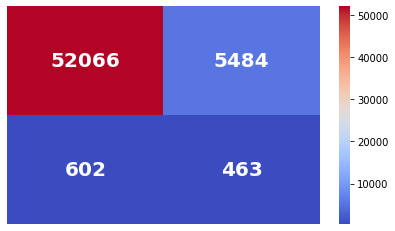

In [18]:
plt.figure(figsize=(7,4))
sns.heatmap(cf_matrix, cmap='coolwarm', annot=True, annot_kws={'size': 20, 'fontweight':'bold'}, fmt='d',
                 xticklabels=False, yticklabels=False);
#plt.savefig('img/cf_matrix.png', bbox_inches='tight')

In [19]:
coef_summary = pd.DataFrame()
coef_summary['feature_name'] = pd.Series(X.columns)
coef_summary['log_reg_coef'] = pd.Series(log_reg.coef_[0])
coef_summary.sort_values('log_reg_coef', inplace = True, ascending=False)
coef_summary

,feature_name,log_reg_coef
3,is_pedestrian,0.451810
0,POSTED_SPEED_LIMIT,0.306702
8,has_stop_sign_or_traffic_light,0.291960
2,is_cyclist,0.259447
9,has_no_controls,0.189749
11,is_night,0.170231
4,is_head_on,0.116895
1,is_weekend,0.067617
7,is_clear_weather,0.033816
12,is_fall,-0.001251


In [20]:
print('Intercept: ', log_reg.intercept_[0])

Intercept:  -0.7156891563570695


### Test for Multicolinearity

In [21]:
X_over_incl_const = sm.add_constant(X_over)
model = sm.Logit(y_over, X_over_incl_const)
results = model.fit(method='newton')
results.summary()

Optimization terminated successfully.
         Current function value: 0.567704
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:      is_fatal_or_incap   No. Observations:               402531
Model:                          Logit   Df Residuals:                   402515
Method:                           MLE   Df Model:                           15
Date:                Wed, 03 Feb 2021   Pseudo R-squ.:                  0.1687
Time:                        07:16:31   Log-Likelihood:            -2.2852e+05
converged:                       True   LL-Null:                   -2.7489e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7157      0.004   -180.846      0.000      -0.723      -0.708
x1             0.3068      0.005     64.401      0.000       0.297       0.316
x2             0.0676      0.004     18.783      0.000       0.061       0.075
x3             0.2595      0.002    104.114      0.000       0.255       0.264
x4             0.4518      0.003    179.724      0.000       0.447       0.457
x5             0.1169      0.003     44.213      0.000       0.112       0.122
x6            -0.3620      0.005    -71.939      0.000      -0.372      -0.352
x7            -0.0184      0.004     -4.304      0.000      -0.027      -0.010
x8             0.0338      0.004      8.379      0.000       0.026       0.042
x9             0.2924      0.010     30.393      0.000       0.274       0.311
x10            0.1902      0.010     19.418      0.000       0.171       0.209
x11           -0.0617      0.004    -15.052      0.000      -0.070      -0.054
x12            0.1703      0.004     44.562      0.000       0.163       0.178
x13           -0.0013      0.004     -0.320      0.749      -0.009       0.006
x14           -0.0372      0.004     -9.067      0.000      -0.045      -0.029
x15           -0.0176      0.004     -4.736      0.000      -0.025      -0.010
==============================================================================
"""

In [22]:
X_over_df = pd.DataFrame(X_over, columns=X.columns)
log_reg_utils.calc_vif(X_over_df)

,features,VIF
0,POSTED_SPEED_LIMIT,1.095351
1,is_weekend,1.038172
2,is_cyclist,1.030213
3,is_pedestrian,1.054724
4,is_head_on,1.012095
5,is_parked,1.239094
6,is_sleet_snow,1.259989
7,is_clear_weather,1.216738
8,has_stop_sign_or_traffic_light,6.768876
9,has_no_controls,6.755577
